In [1]:
from tool import *
import torch

In [2]:
class Critic(torch.nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2),
        )

    def forward(self, state):
        return self.fc(state)  # Shape: [batch_size, num_actions]
    
class Actor(torch.nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, state):
        return self.fc(state)  # Shape: [batch_size, num_actions]
    
# Initialize Models
model_actor = Actor()
model_critic = Critic()
model_critic_delay = Critic()
model_critic_delay.load_state_dict(model_critic.state_dict())
model_actor , model_critic

(Actor(
   (fc): Sequential(
     (0): Linear(in_features=4, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=2, bias=True)
     (5): Softmax(dim=1)
   )
 ),
 Critic(
   (fc): Sequential(
     (0): Linear(in_features=4, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=2, bias=True)
   )
 ))

In [3]:
# Initialize Optimizers (Removed duplicate definitions)
learning_rate_actor = 1e-3  # Adjusted learning rate for actor
learning_rate_critic = 1e-2  # Adjusted learning rate for critic

optimizer_actor = torch.optim.Adam(model_actor.parameters(), lr=learning_rate_actor)
optimizer_critic = torch.optim.Adam(model_critic.parameters(), lr=learning_rate_critic)

In [4]:
from IPython import display
import numpy as np
import random

def play(show = False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []
    
    s = env.reset()
    o = False
    while not o:
        prob = model_actor(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]
        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()
    state = np.array(state)
    action = np.array(action)
    reward = np.array(reward)
    next_state = np.array(next_state)
    over = np.array(over)
    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)
    next_state = torch.FloatTensor(next_state).reshape(-1, 4)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()

In [5]:
# Define Helper Function to Toggle Gradients
def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad = value

In [6]:
import torch.nn.functional as F
def train_critic(state, reward, next_state, over):
    requires_grad(model_actor, False)
    requires_grad(model_critic, True)

    #计算values和targets
    value = model_critic(state)

    with torch.no_grad():
        target = model_critic_delay(next_state)
    target = target * 0.99 * (1 - over) + reward

    #时序差分误差,也就是tdloss
    loss = torch.nn.functional.mse_loss(value, target)

    loss.backward()
    optimizer_critic.step()
    optimizer_critic.zero_grad()

    #减去value相当于去基线
    return (target - value).detach()

In [7]:
def train_actor(state, action, value):
    requires_grad(model_actor, True)
    requires_grad(model_critic, False)

    #重新计算动作的概率
    prob = model_actor(state)
    prob = prob.gather(dim=1, index=action)

    #根据策略梯度算法的导函数实现
    #函数中的Q(state,action),这里使用critic模型估算
    prob = (prob + 1e-8).log() * value
    loss = -prob.mean()

    loss.backward()
    optimizer_actor.step()
    optimizer_actor.zero_grad()

    return loss.item()

In [8]:
def train():
    model_actor.train()
    model_critic.train()

    #训练N局
    for epoch in range(1000):

        #一个epoch最少玩N步
        steps = 0
        while steps < 200:
            state, action, reward, next_state, over, _ = play()
            steps += len(state)

            #训练两个模型
            value = train_critic(state, reward, next_state, over)
            loss = train_actor(state, action, value)

        #复制参数
        for param, param_delay in zip(model_critic.parameters(),
                                      model_critic_delay.parameters()):
            value = param_delay.data * 0.7 + param.data * 0.3
            param_delay.data.copy_(value)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 -13.547459602355957 -975.4
100 -7.610259056091309 -587.5
200 -2.0842206478118896 -4.3
300 -0.31977248191833496 -258.0
400 -1.4571439027786255 149.15
500 -0.9527031183242798 200.0
600 -0.7511638402938843 200.0
700 -0.47051215171813965 200.0
800 -0.29454824328422546 200.0
900 -0.5785565376281738 200.0


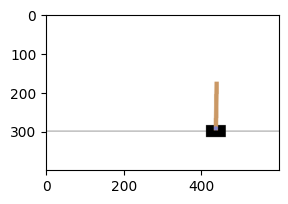

200.0

In [9]:
play(True)[-1]